# MLB Player Performance Projection - Part 1: Data Preparation
 
**Project**: MLB Player Performance Projection System  
**Notebook**: 01 - Data Collection & Preparation  
**Author**: Yunjae Jung 
**Date**: January 2026
 
## Objectives
- Load Lahman Baseball Database
- Prepare batting statistics for analysis
- Calculate key metrics (OPS, WAR estimates)
- Create year-to-year player performance dataset
- Filter to recent, qualified players
 
## Context
This project builds a player projection system similar to STEAMER, ZiPS, and PECOTA systems that MLB teams use daily to forecast player performance and make roster decisions.


## 1. Setup & Imports

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set visualization defaults
sns.set_style('whitegrid')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.3f}'.format)

print("✓ Libraries imported successfully")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")


✓ Libraries imported successfully
Pandas version: 2.3.2
NumPy version: 2.3.3


## 2. Load Lahman Database

In [16]:
# Define paths
DATA_DIR = Path('../data')
RAW_DATA = DATA_DIR / 'raw'
PROCESSED_DATA = DATA_DIR / 'processed'

# Create directories
PROCESSED_DATA.mkdir(parents=True, exist_ok=True)

print(f"Data directory: {RAW_DATA}")


Data directory: ../data/raw


### 2.1 Load Core Tables

In [17]:
# Load batting statistics
batting = pd.read_csv(RAW_DATA / 'Batting.csv')
print(f"✓ Batting data loaded: {batting.shape}")

# Load people (player info)
people = pd.read_csv(RAW_DATA / 'People.csv')
print(f"✓ People data loaded: {people.shape}")

# Load teams
teams = pd.read_csv(RAW_DATA / 'Teams.csv')
print(f"✓ Teams data loaded: {teams.shape}")

# Preview batting data
print("\nBatting Data Sample:")
print("=" * 80)
batting.head()

# Check columns
print("\nBatting columns:")
print(batting.columns.tolist())

# Data info
print("\nBatting Data Info:")
print("=" * 80)
batting.info()

✓ Batting data loaded: (128598, 22)
✓ People data loaded: (24270, 25)
✓ Teams data loaded: (3614, 48)

Batting Data Sample:

Batting columns:
['playerID', 'yearID', 'stint', 'teamID', 'lgID', 'G', 'AB', 'R', 'H', '2B', '3B', 'HR', 'RBI', 'SB', 'CS', 'BB', 'SO', 'IBB', 'HBP', 'SH', 'SF', 'GIDP']

Batting Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128598 entries, 0 to 128597
Data columns (total 22 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   playerID  128598 non-null  object 
 1   yearID    128598 non-null  int64  
 2   stint     128598 non-null  int64  
 3   teamID    128598 non-null  object 
 4   lgID      127861 non-null  object 
 5   G         128598 non-null  int64  
 6   AB        128598 non-null  int64  
 7   R         128598 non-null  int64  
 8   H         128598 non-null  int64  
 9   2B        128598 non-null  int64  
 10  3B        128598 non-null  int64  
 11  HR        128598 non-null  int64  
 12  RBI     

## 3. Data Quality Assessment

In [18]:
# Check for missing values
print("Missing Values in Batting Data:")
print("=" * 80)
missing = batting.isnull().sum()
missing_pct = (missing / len(batting)) * 100
missing_df = pd.DataFrame({
    'Missing Count': missing,
    'Percentage': missing_pct
}).sort_values('Missing Count', ascending=False)

print(missing_df[missing_df['Missing Count'] > 0].head(10))

# Year range
print(f"\nYear Range: {batting['yearID'].min()} - {batting['yearID'].max()}")
print(f"Total player-seasons: {len(batting):,}")
print(f"Unique players: {batting['playerID'].nunique():,}")


Missing Values in Batting Data:
      Missing Count  Percentage
SF            46664      36.287
IBB           46527      36.180
GIDP          35432      27.553
CS            32495      25.269
SO             8859       6.889
SH             6068       4.719
HBP            2816       2.190
SB             2546       1.980
RBI             756       0.588
lgID            737       0.573

Year Range: 1871 - 2025
Total player-seasons: 128,598
Unique players: 24,011


## 4. Focus on Modern Era

In [19]:
# Focus on modern era (2000-2025) for relevance
# This gives us complete data through 2025 season for validation
MODERN_ERA_START = 2000
MODERN_ERA_END = 2025

batting_modern = batting[
    (batting['yearID'] >= MODERN_ERA_START) & 
    (batting['yearID'] <= MODERN_ERA_END)
].copy()

print(f"Modern era data ({MODERN_ERA_START}-{MODERN_ERA_END}):")
print(f"  Player-seasons: {len(batting_modern):,}")
print(f"  Unique players: {batting_modern['playerID'].nunique():,}")
print(f"  Seasons: {batting_modern['yearID'].nunique()}")

print(f"\n📊 Data Split Plan:")
print(f"  Training:   2000-2023 (24 seasons)")
print(f"  Validation: 2024 (1 season) ← Can verify predictions!")
print(f"  Test:       2025 (1 season) ← Can verify predictions!")
print(f"\n💡 Both 2024 and 2025 have actual results for validation!")


Modern era data (2000-2025):
  Player-seasons: 37,876
  Unique players: 7,163
  Seasons: 26

📊 Data Split Plan:
  Training:   2000-2023 (24 seasons)
  Validation: 2024 (1 season) ← Can verify predictions!
  Test:       2025 (1 season) ← Can verify predictions!

💡 Both 2024 and 2025 have actual results for validation!


## 5. Calculate Advanced Metrics

### 5.1 Basic Rate Stats

In [20]:
# Calculate batting average, on-base percentage, slugging
print("Calculating rate statistics...")

# Batting Average
batting_modern['AVG'] = np.where(
    batting_modern['AB'] > 0,
    batting_modern['H'] / batting_modern['AB'],
    0
)

# On-Base Percentage
batting_modern['OBP'] = np.where(
    (batting_modern['AB'] + batting_modern['BB'] + batting_modern['HBP'] + batting_modern['SF']) > 0,
    (batting_modern['H'] + batting_modern['BB'] + batting_modern['HBP']) / 
    (batting_modern['AB'] + batting_modern['BB'] + batting_modern['HBP'] + batting_modern['SF']),
    0
)

# Slugging Percentage
batting_modern['1B'] = batting_modern['H'] - batting_modern['2B'] - batting_modern['3B'] - batting_modern['HR']
batting_modern['TB'] = (batting_modern['1B'] + 
                        2 * batting_modern['2B'] + 
                        3 * batting_modern['3B'] + 
                        4 * batting_modern['HR'])
batting_modern['SLG'] = np.where(
    batting_modern['AB'] > 0,
    batting_modern['TB'] / batting_modern['AB'],
    0
)

# OPS (On-base Plus Slugging)
batting_modern['OPS'] = batting_modern['OBP'] + batting_modern['SLG']

print("✓ Rate statistics calculated")

# Display sample
print("\nSample with calculated stats:")
print(batting_modern[['playerID', 'yearID', 'AB', 'H', 'HR', 'AVG', 'OBP', 'SLG', 'OPS']].head(10))


Calculating rate statistics...
✓ Rate statistics calculated

Sample with calculated stats:
     playerID  yearID  AB  H  HR   AVG   OBP   SLG   OPS
0   aardsda01    2004   0  0   0 0.000 0.000 0.000 0.000
1   aardsda01    2006   2  0   0 0.000 0.000 0.000 0.000
2   aardsda01    2007   0  0   0 0.000 0.000 0.000 0.000
3   aardsda01    2008   1  0   0 0.000 0.000 0.000 0.000
4   aardsda01    2009   0  0   0 0.000 0.000 0.000 0.000
5   aardsda01    2010   0  0   0 0.000 0.000 0.000 0.000
6   aardsda01    2012   0  0   0 0.000 0.000 0.000 0.000
7   aardsda01    2013   0  0   0 0.000 0.000 0.000 0.000
8   aardsda01    2015   1  0   0 0.000 0.000 0.000 0.000
52   abadan01    2001   1  0   0 0.000 0.000 0.000 0.000


### 5.2 Quality Filter - Qualified Batters

In [21]:
# MLB qualification: 3.1 PA per team game (502 PA in 162-game season)
# We'll use a more lenient 300 PA threshold to capture more data

MIN_PA = 300

# Calculate PA (Plate Appearances)
batting_modern['PA'] = (batting_modern['AB'] + 
                        batting_modern['BB'] + 
                        batting_modern['HBP'] + 
                        batting_modern['SF'] + 
                        batting_modern['SH'])

# Filter qualified batters
batting_qualified = batting_modern[batting_modern['PA'] >= MIN_PA].copy()

print(f"Qualified batters (≥{MIN_PA} PA):")
print(f"  Player-seasons: {len(batting_qualified):,}")
print(f"  Unique players: {batting_qualified['playerID'].nunique():,}")
print(f"  Average PA: {batting_qualified['PA'].mean():.0f}")


Qualified batters (≥300 PA):
  Player-seasons: 6,637
  Unique players: 1,479
  Average PA: 508


## 6. Add Player Information

In [22]:
# Merge with people data to get ages
people_subset = people[['playerID', 'nameFirst', 'nameLast', 'birthYear']].copy()

batting_with_info = batting_qualified.merge(
    people_subset,
    on='playerID',
    how='left'
)

# Calculate age
batting_with_info['age'] = batting_with_info['yearID'] - batting_with_info['birthYear']

# Create full name
batting_with_info['playerName'] = (
    batting_with_info['nameFirst'] + ' ' + batting_with_info['nameLast']
)

print("✓ Player information merged")
print(f"\nAge range: {batting_with_info['age'].min():.0f} - {batting_with_info['age'].max():.0f}")
print(f"Average age: {batting_with_info['age'].mean():.1f}")

# Sample with player names
print("\nSample data with player info:")
batting_with_info[['playerName', 'yearID', 'age', 'G', 'PA', 'AVG', 'HR', 'OPS']].head(10)


✓ Player information merged

Age range: 20 - 46
Average age: 29.2

Sample data with player info:


,playerName,yearID,age,G,PA,AVG,HR,OPS
0,Brent Abernathy,2001,24.000,79,335.000,0.270,5,0.710
1,Brent Abernathy,2002,25.000,117,504.000,0.242,2,0.599
2,CJ Abrams,2023,23.000,151,614.000,0.245,18,0.712
3,CJ Abrams,2024,24.000,138,602.000,0.246,20,0.747
4,CJ Abrams,2025,25.000,144,635.000,0.257,19,0.748
5,Bobby Abreu,2000,26.000,154,680.000,0.316,25,0.970
6,Bobby Abreu,2001,27.000,162,704.000,0.289,31,0.936
7,Bobby Abreu,2002,28.000,157,685.000,0.308,20,0.934
8,Bobby Abreu,2003,29.000,158,695.000,0.300,20,0.877
9,Bobby Abreu,2004,30.000,159,713.000,0.301,30,0.971


## 7. Create Year-to-Year Dataset


### 7.1 Prepare for Prediction Task

In [23]:
# Goal: Predict Year N+1 performance based on Year N
# Strategy: Use all data including 2025 for shift, then filter out 2025

print("Creating year-to-year dataset...")

# Sort by player and year (include 2025 for now)
batting_sorted = batting_with_info.sort_values(['playerID', 'yearID']).copy()

# Create next year stats (2025 will help create 2024's targets)
stats_to_predict = ['AVG', 'OBP', 'SLG', 'OPS', 'HR', 'RBI', 'SB']

for stat in stats_to_predict:
    batting_sorted[f'{stat}_next'] = batting_sorted.groupby('playerID')[stat].shift(-1)

# Also track next year's PA to filter later
batting_sorted['PA_next'] = batting_sorted.groupby('playerID')['PA'].shift(-1)

print("✓ Next year stats created")
print(f"  Data includes: {batting_sorted['yearID'].min()} - {batting_sorted['yearID'].max()}")

# Remove rows without next year data (this will exclude 2025)
# Also filter out 2025 explicitly since it has no 2026 target
batting_with_next = batting_sorted[
    (batting_sorted['PA_next'].notna()) & 
    (batting_sorted['yearID'] < 2025)  # Explicitly exclude 2025
].copy()

# Only keep players who qualified in BOTH years
batting_with_next = batting_with_next[batting_with_next['PA_next'] >= MIN_PA].copy()

print(f"\nYear-to-year dataset (for training/validation):")
print(f"  Records: {len(batting_with_next):,}")
print(f"  Unique players: {batting_with_next['playerID'].nunique():,}")
print(f"  Year range: {batting_with_next['yearID'].min()} - {batting_with_next['yearID'].max()}")

print(f"\n💡 NOTE:")
print(f"  • 2025 excluded (no 2026 data for validation)")
print(f"  • 2024 included with 2025 as target ✓")
print(f"  • Final dataset: 2000-2024")

Creating year-to-year dataset...
✓ Next year stats created
  Data includes: 2000 - 2025

Year-to-year dataset (for training/validation):
  Records: 5,157
  Unique players: 1,157
  Year range: 2000 - 2024

💡 NOTE:
  • 2025 excluded (no 2026 data for validation)
  • 2024 included with 2025 as target ✓
  • Final dataset: 2000-2024


## 8. Calculate Career Statistics

In [24]:
# Calculate cumulative career stats up to each season
print("Calculating career statistics...")

batting_with_next = batting_with_next.sort_values(['playerID', 'yearID'])

# Career games, PA, hits through current year
for stat in ['G', 'PA', 'AB', 'H', 'HR', 'RBI']:
    batting_with_next[f'career_{stat}'] = (
        batting_with_next.groupby('playerID')[stat].cumsum()
    )

# Years of experience
batting_with_next['years_experience'] = (
    batting_with_next.groupby('playerID').cumcount() + 1
)

print("✓ Career statistics calculated")

# Sample with career stats
print("\nSample with career stats:")
career_cols = ['playerName', 'yearID', 'years_experience', 'career_G', 'career_HR', 'OPS']
print(batting_with_next[career_cols].head(10))


Calculating career statistics...
✓ Career statistics calculated

Sample with career stats:
         playerName  yearID  years_experience  career_G  career_HR   OPS
0   Brent Abernathy    2001                 1        79          5 0.710
2         CJ Abrams    2023                 1       151         18 0.712
3         CJ Abrams    2024                 2       289         38 0.747
5       Bobby Abreu    2000                 1       154         25 0.970
6       Bobby Abreu    2001                 2       316         56 0.936
7       Bobby Abreu    2002                 3       473         76 0.934
8       Bobby Abreu    2003                 4       631         96 0.877
9       Bobby Abreu    2004                 5       790        126 0.971
10      Bobby Abreu    2005                 6       952        150 0.879
11      Bobby Abreu    2006                 7      1050        158 0.861


## 9. Age Grouping

In [25]:
# Create age groups for analysis
batting_with_next['age_group'] = pd.cut(
    batting_with_next['age'],
    bins=[0, 23, 26, 29, 32, 35, 100],
    labels=['<24', '24-26', '27-29', '30-32', '33-35', '36+']
)

print("Age distribution:")
print(batting_with_next['age_group'].value_counts().sort_index())


Age distribution:
age_group
<24       309
24-26    1261
27-29    1543
30-32    1174
33-35     597
36+       273
Name: count, dtype: int64


## 10. Data Quality Summary

In [26]:
print("=" * 80)
print("DATA PREPARATION SUMMARY")
print("=" * 80)

print(f"\n📊 Final Dataset:")
print(f"   Total records: {len(batting_with_next):,}")
print(f"   Unique players: {batting_with_next['playerID'].nunique():,}")
print(f"   Year range: {batting_with_next['yearID'].min()} - {batting_with_next['yearID'].max()}")
print(f"   Average PA: {batting_with_next['PA'].mean():.0f}")

print(f"\n🎯 Projection Validation:")
print(f"   2024 predictions: Can verify (season complete)")
print(f"   2025 season data: Available for 2026 projections")
print(f"   Training data: 2000-2024 (25 years)")

print(f"\n👤 Player Demographics:")
print(f"   Age range: {batting_with_next['age'].min():.0f} - {batting_with_next['age'].max():.0f}")
print(f"   Average age: {batting_with_next['age'].mean():.1f}")
print(f"   Average experience: {batting_with_next['years_experience'].mean():.1f} years")

print(f"\n⚾ Performance Metrics:")
print(f"   Average OPS: {batting_with_next['OPS'].mean():.3f}")
print(f"   Average HR: {batting_with_next['HR'].mean():.1f}")
print(f"   Average AVG: {batting_with_next['AVG'].mean():.3f}")

print(f"\n✅ Features Available:")
print(f"   Current season stats: {len([c for c in batting_with_next.columns if not c.endswith('_next')])}")
print(f"   Prediction targets: {len(stats_to_predict)}")


DATA PREPARATION SUMMARY

📊 Final Dataset:
   Total records: 5,157
   Unique players: 1,157
   Year range: 2000 - 2024
   Average PA: 529

🎯 Projection Validation:
   2024 predictions: Can verify (season complete)
   2025 season data: Available for 2026 projections
   Training data: 2000-2024 (25 years)

👤 Player Demographics:
   Age range: 20 - 44
   Average age: 28.8
   Average experience: 4.0 years

⚾ Performance Metrics:
   Average OPS: 0.782
   Average HR: 17.1
   Average AVG: 0.270

✅ Features Available:
   Current season stats: 42
   Prediction targets: 7


## 11. Basic Visualizations

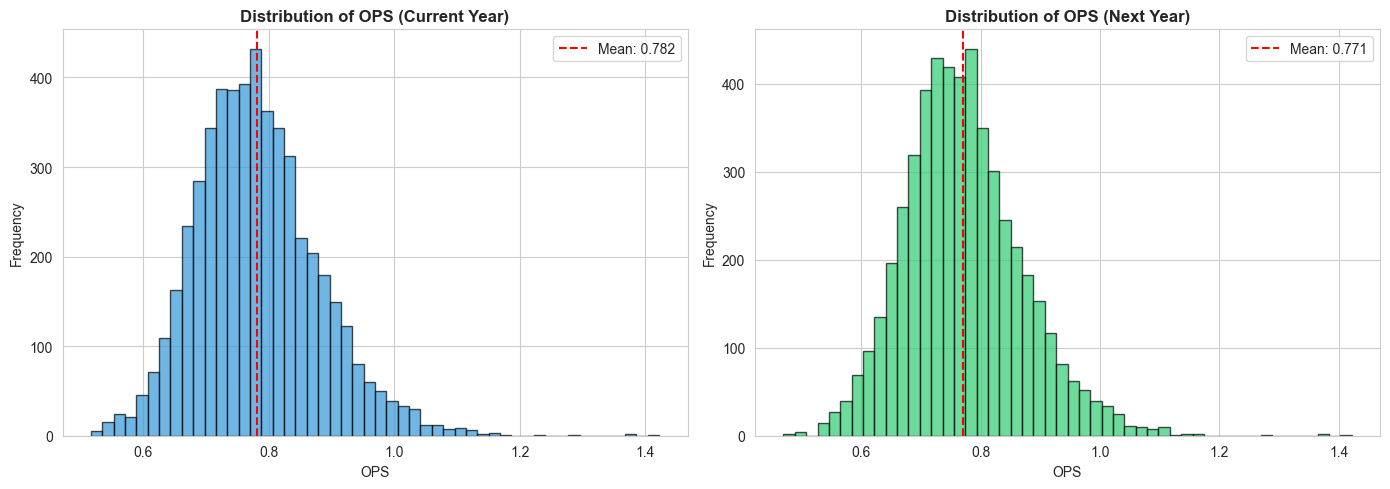

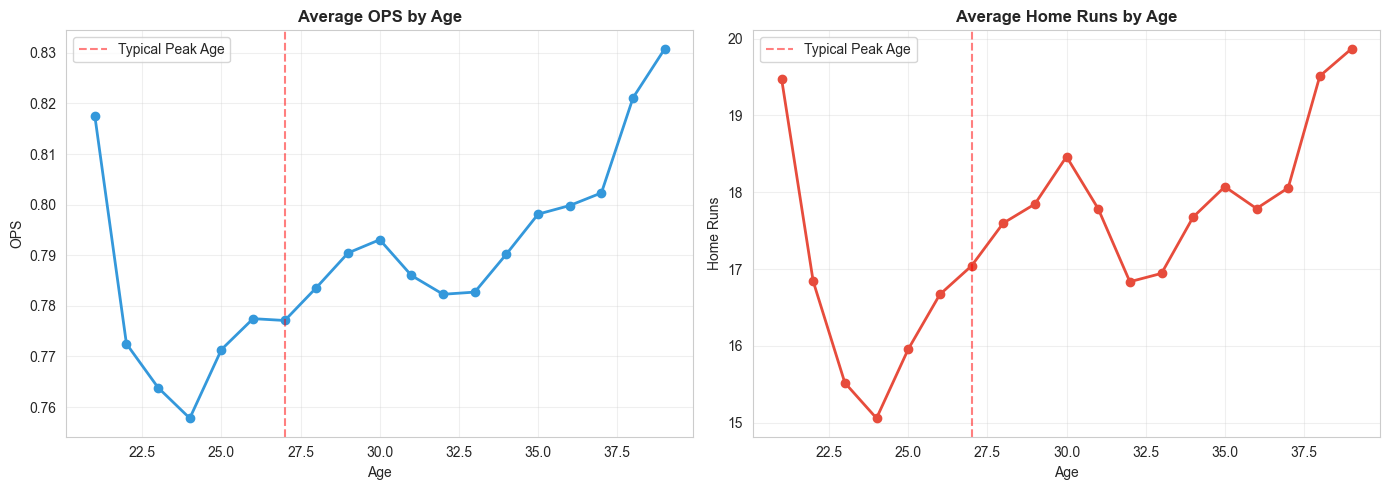


💡 INSIGHT: Players typically peak around age 27-28

Year-to-year correlation:
AVG        → AVG_next: 0.450
OBP        → OBP_next: 0.563
SLG        → SLG_next: 0.542
OPS        → OPS_next: 0.541
HR         → HR_next: 0.652
RBI        → RBI_next: 0.562
SB         → SB_next: 0.769

💡 INSIGHT: Strong correlation = stat stability
   Higher correlation = more predictable


In [27]:
# Distribution of OPS
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Current year OPS
axes[0].hist(batting_with_next['OPS'], bins=50, color='#3498db', edgecolor='black', alpha=0.7)
axes[0].set_title('Distribution of OPS (Current Year)', fontsize=12, fontweight='bold')
axes[0].set_xlabel('OPS')
axes[0].set_ylabel('Frequency')
axes[0].axvline(batting_with_next['OPS'].mean(), color='red', linestyle='--', 
                label=f'Mean: {batting_with_next["OPS"].mean():.3f}')
axes[0].legend()

# Next year OPS
axes[1].hist(batting_with_next['OPS_next'], bins=50, color='#2ecc71', edgecolor='black', alpha=0.7)
axes[1].set_title('Distribution of OPS (Next Year)', fontsize=12, fontweight='bold')
axes[1].set_xlabel('OPS')
axes[1].set_ylabel('Frequency')
axes[1].axvline(batting_with_next['OPS_next'].mean(), color='red', linestyle='--',
                label=f'Mean: {batting_with_next["OPS_next"].mean():.3f}')
axes[1].legend()

plt.tight_layout()
plt.show()

# Performance by age
age_performance = batting_with_next.groupby('age').agg({
    'OPS': 'mean',
    'HR': 'mean',
    'playerID': 'count'
}).rename(columns={'playerID': 'count'})

age_performance = age_performance[age_performance['count'] >= 20]  # At least 20 players

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# OPS by age
axes[0].plot(age_performance.index, age_performance['OPS'], marker='o', linewidth=2, color='#3498db')
axes[0].set_title('Average OPS by Age', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Age')
axes[0].set_ylabel('OPS')
axes[0].grid(alpha=0.3)
axes[0].axvline(x=27, color='red', linestyle='--', alpha=0.5, label='Typical Peak Age')
axes[0].legend()

# HR by age
axes[1].plot(age_performance.index, age_performance['HR'], marker='o', linewidth=2, color='#e74c3c')
axes[1].set_title('Average Home Runs by Age', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Age')
axes[1].set_ylabel('Home Runs')
axes[1].grid(alpha=0.3)
axes[1].axvline(x=27, color='red', linestyle='--', alpha=0.5, label='Typical Peak Age')
axes[1].legend()

plt.tight_layout()
plt.show()

print("\n💡 INSIGHT: Players typically peak around age 27-28")

# Year-to-year correlation
print("\nYear-to-year correlation:")
print("=" * 50)

for stat in stats_to_predict:
    if f'{stat}_next' in batting_with_next.columns:
        corr = batting_with_next[stat].corr(batting_with_next[f'{stat}_next'])
        print(f"{stat:10s} → {stat}_next: {corr:.3f}")

print("\n💡 INSIGHT: Strong correlation = stat stability")
print("   Higher correlation = more predictable")


## 12. Save Processed Data

In [28]:
# Select final columns
final_columns = [
    # Identifiers
    'playerID', 'playerName', 'yearID', 'teamID',
    
    # Demographics
    'age', 'age_group', 'years_experience',
    
    # Current season counting stats
    'G', 'PA', 'AB', 'H', '2B', '3B', 'HR', 'RBI', 'SB', 'BB', 'SO',
    
    # Current season rate stats
    'AVG', 'OBP', 'SLG', 'OPS',
    
    # Career stats
    'career_G', 'career_PA', 'career_HR',
    
    # Next year targets
    'AVG_next', 'OBP_next', 'SLG_next', 'OPS_next', 'HR_next', 'RBI_next', 'SB_next',
    'PA_next'
]

# Create final dataset
final_data = batting_with_next[final_columns].copy()

# Save for next notebook
output_path = PROCESSED_DATA / 'batting_with_projections.csv'
final_data.to_csv(output_path, index=False)

# Also save 2025 data separately for future projections
batting_2025 = batting_with_info[
    (batting_with_info['yearID'] == 2025) & 
    (batting_with_info['PA'] >= MIN_PA)
].copy()

if len(batting_2025) > 0:
    output_2025 = PROCESSED_DATA / 'batting_2025_for_projection.csv'
    batting_2025.to_csv(output_2025, index=False)
    print(f"✓ 2025 data saved separately: {output_2025}")
    print(f"  Records: {len(batting_2025)}")
    print(f"  Purpose: Real-world 2026 projections")

print(f"\n✓ Main training data saved to: {output_path}")
print(f"  Shape: {final_data.shape}")
print(f"  Columns: {len(final_data.columns)}")

# Final preview
print("\nFinal Dataset Preview:")
print("=" * 80)
final_data.head(10)

✓ 2025 data saved separately: ../data/processed/batting_2025_for_projection.csv
  Records: 268
  Purpose: Real-world 2026 projections

✓ Main training data saved to: ../data/processed/batting_with_projections.csv
  Shape: (5157, 33)
  Columns: 33

Final Dataset Preview:


,playerID,playerName,yearID,teamID,age,age_group,years_experience,G,PA,AB,H,2B,3B,HR,RBI,SB,BB,SO,AVG,OBP,SLG,OPS,career_G,career_PA,career_HR,AVG_next,OBP_next,SLG_next,OPS_next,HR_next,RBI_next,SB_next,PA_next
0,abernbr01,Brent Abernathy,2001,TBA,24.000,24-26,1,79,335.000,304,82,17,1,5,33.000,8.000,27,35.000,0.270,0.328,0.382,0.710,79,335.000,5,0.242,0.288,0.311,0.599,2.000,40.000,10.000,504.000
2,abramcj01,CJ Abrams,2023,WAS,23.000,<24,1,151,614.000,563,138,28,6,18,64.000,47.000,32,118.000,0.245,0.300,0.412,0.712,151,614.000,18,0.246,0.314,0.433,0.747,20.000,65.000,31.000,602.000
3,abramcj01,CJ Abrams,2024,WAS,24.000,24-26,2,138,602.000,541,133,29,6,20,65.000,31.000,40,128.000,0.246,0.314,0.433,0.747,289,1216.000,38,0.257,0.315,0.433,0.748,19.000,60.000,31.000,635.000
5,abreubo01,Bobby Abreu,2000,PHI,26.000,24-26,1,154,680.000,576,182,42,10,25,79.000,28.000,100,116.000,0.316,0.416,0.554,0.970,154,680.000,25,0.289,0.393,0.543,0.936,31.000,110.000,36.000,704.000
6,abreubo01,Bobby Abreu,2001,PHI,27.000,27-29,2,162,704.000,588,170,48,4,31,110.000,36.000,106,137.000,0.289,0.393,0.543,0.936,316,1384.000,56,0.308,0.413,0.521,0.934,20.000,85.000,31.000,685.000
7,abreubo01,Bobby Abreu,2002,PHI,28.000,27-29,3,157,685.000,572,176,50,6,20,85.000,31.000,104,117.000,0.308,0.413,0.521,0.934,473,2069.000,76,0.300,0.409,0.468,0.877,20.000,101.000,22.000,695.000
8,abreubo01,Bobby Abreu,2003,PHI,29.000,27-29,4,158,695.000,577,173,35,1,20,101.000,22.000,109,126.000,0.300,0.409,0.468,0.877,631,2764.000,96,0.301,0.428,0.544,0.971,30.000,105.000,40.000,713.000
9,abreubo01,Bobby Abreu,2004,PHI,30.000,30-32,5,159,713.000,574,173,47,1,30,105.000,40.000,127,116.000,0.301,0.428,0.544,0.971,790,3477.000,126,0.286,0.405,0.474,0.879,24.000,102.000,31.000,719.000
10,abreubo01,Bobby Abreu,2005,PHI,31.000,30-32,6,162,719.000,588,168,37,1,24,102.000,31.000,117,134.000,0.286,0.405,0.474,0.879,952,4196.000,150,0.277,0.427,0.434,0.861,8.000,65.000,20.000,438.000
11,abreubo01,Bobby Abreu,2006,PHI,32.000,30-32,7,98,438.000,339,94,25,2,8,65.000,20.000,91,86.000,0.277,0.427,0.434,0.861,1050,4634.000,158,0.283,0.369,0.445,0.814,16.000,101.000,25.000,699.000
